In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


In [2]:
data = pd.read_csv("Q1/communities.csv")
data = data.replace('?', np.NaN)
data_to_use = data.drop(columns=[' state ', ' county ', ' community ', ' communityname string', ' fold '])
print(np.sum(data_to_use.isna()))
print(data_to_use.shape)

 population                 0
 householdsize              0
 racepctblack               0
 racePctWhite               0
 racePctAsian               0
                         ... 
 LemasPctPolicOnPatr     1675
 LemasGangUnitDeploy     1675
 LemasPctOfficDrugUn        0
 PolicBudgPerPop         1675
 ViolentCrimesPerPop        0
Length: 123, dtype: int64
(1994, 123)


In [3]:
# Data Cleaning process
threshold = 700
columns_to_remove = []
for column in data_to_use.columns.values:
    if np.sum(data_to_use[column].isna()) > threshold:
        # add this column to the list that should be removed
        columns_to_remove.append(column)
        
print(columns_to_remove)
print(len(columns_to_remove))
# now lets remove them
data_filtered_cols = data_to_use.drop(columns_to_remove, axis=1)
print(data_filtered_cols.shape)
data_filtered = data_filtered_cols.dropna()
data_filtered = data_filtered.convert_dtypes()
display(data_filtered.dtypes)

[' LemasSwornFT ', ' LemasSwFTPerPop ', ' LemasSwFTFieldOps ', ' LemasSwFTFieldPerPop ', ' LemasTotalReq ', ' LemasTotReqPerPop ', ' PolicReqPerOffic ', ' PolicPerPop ', ' RacialMatchCommPol ', ' PctPolicWhite ', ' PctPolicBlack ', ' PctPolicHisp ', ' PctPolicAsian ', ' PctPolicMinor ', ' OfficAssgnDrugUnits ', ' NumKindsDrugsSeiz ', ' PolicAveOTWorked ', ' PolicCars ', ' PolicOperBudg ', ' LemasPctPolicOnPatr ', ' LemasGangUnitDeploy ', ' PolicBudgPerPop ']
22
(1994, 101)


 population              Float64
 householdsize           Float64
 racepctblack            Float64
 racePctWhite            Float64
 racePctAsian            Float64
                          ...   
 LandArea                Float64
 PopDens                 Float64
 PctUsePubTrans          Float64
 LemasPctOfficDrugUn     Float64
 ViolentCrimesPerPop     Float64
Length: 101, dtype: object

In [4]:
print(data_filtered.iloc[:,:])

       population    householdsize    racepctblack    racePctWhite   \
0             0.19             0.33            0.02             0.9   
1              0.0             0.16            0.12            0.74   
2              0.0             0.42            0.49            0.56   
3             0.04             0.77             1.0            0.08   
4             0.01             0.55            0.02            0.95   
...            ...              ...             ...             ...   
1989          0.01              0.4             0.1            0.87   
1990          0.05             0.96            0.46            0.28   
1991          0.16             0.37            0.25            0.69   
1992          0.08             0.51            0.06            0.87   
1993           0.2             0.78            0.14            0.46   

       racePctAsian    racePctHisp    agePct12t21    agePct12t29   \
0               0.12           0.17           0.34           0.47   
1        

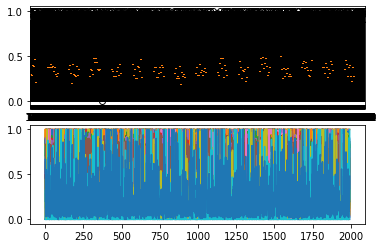

In [5]:
# data_filtered.plot.box(title="Box and whisker plot", grid=True)
data_filtered = data_filtered.astype(float)

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.boxplot(data_filtered.transpose())
ax = fig.add_subplot(2, 1, 2)
ax.plot(data_filtered)
plt.show()

In [6]:
data_filtered.reset_index(inplace=True, drop=True)

In [7]:
y = data_filtered[" ViolentCrimesPerPop "]
X = data_filtered.drop([" ViolentCrimesPerPop "], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 
print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (1195, 100)
X_val shape: (399, 100)
X_test shape: (399, 100)


[ 0.49198548  0.06328822  0.21098181 -0.02195918  0.05091358  0.03881359
  0.20206361 -0.12186704 -0.20360536  0.25594055 -0.55879413  0.05417517
 -0.29043132 -0.18654952  0.03928884 -0.13492306  0.05750657  0.05093048
 -0.07476393  0.35010089  0.24149733 -0.45159887 -0.02493657 -0.02842529
  0.05032477  0.03610106  0.04382478 -0.09862953 -0.14323986  0.00850184
 -0.08572037 -0.02781275  0.04748329  0.42858975 -0.03991075 -0.03162662
  0.03882825  0.16154993  0.22419279  0.21666076 -0.14108305 -0.03476421
 -0.06797359 -0.05316204 -0.25693544  0.03622483 -0.00668306  0.0262685
 -0.18066806 -0.18200626  0.25507293 -0.10795392 -0.03742166  0.1348626
 -0.05803981  0.0423366   0.07984789 -0.19189113  0.02697158  0.020363
 -0.05965655 -0.20677796 -0.21833251 -0.0430851   0.70890163 -0.34103707
 -0.07099108  0.21812406  0.38741721  0.15981754  0.06400707  0.33792522
  0.01764975 -0.21877328  0.05255416 -0.04775391 -0.03624971  0.02070514
 -0.00314389 -0.11478999 -0.05686369  0.08776463 -0.248

In [9]:
# OLS version
model = sm.OLS(y_train, X_train)
trained_model = model.fit()
print(trained_model.summary())

                                  OLS Regression Results                                  
Dep. Variable:      ViolentCrimesPerPop    R-squared (uncentered):                   0.861
Model:                               OLS   Adj. R-squared (uncentered):              0.849
Method:                    Least Squares   F-statistic:                              67.99
Date:                   Sun, 21 Mar 2021   Prob (F-statistic):                        0.00
Time:                           14:24:35   Log-Likelihood:                          801.57
No. Observations:                   1195   AIC:                                     -1403.
Df Residuals:                       1095   BIC:                                     -894.6
Df Model:                            100                                                  
Covariance Type:               nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975

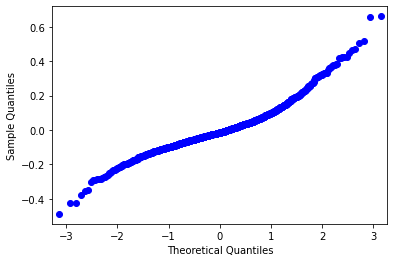

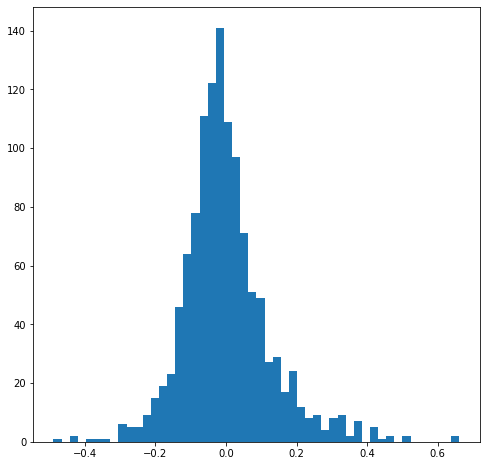

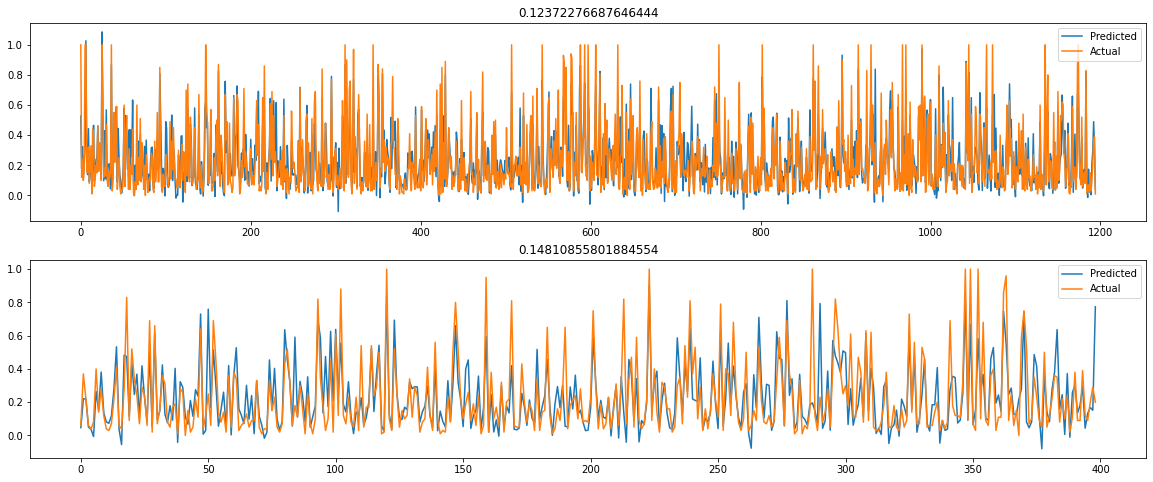

In [11]:
f = sm.qqplot(trained_model.resid)
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.hist(trained_model.resid, 50)

y_train_pred = trained_model.predict(X_train.astype(float))
y_test_pred = trained_model.predict(X_test.astype(float))
rmse_train = np.sqrt(np.mean((y_train_pred - y_train)**2))
rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(len(y_train_pred)), y_train_pred, label='Predicted')
ax.plot(np.arange(len(y_train_pred)), y_train.astype(float), label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.arange(len(y_test_pred)), y_test_pred, label='Predicted')
ax.plot(np.arange(len(y_test_pred)), y_test.astype(float), label='Actual')
ax.set_title(rmse_test)
ax.legend();

In [13]:
# Fit to Regression model
model_sk = LinearRegression(fit_intercept = False).fit(X = X_train.to_numpy(), y = y_train.to_numpy())
print(model_sk.coef_)
print(model_sk.score(X_train.to_numpy(), y_train.to_numpy()))

[ 0.49198548  0.06328822  0.21098181 -0.02195918  0.05091358  0.03881359
  0.20206361 -0.12186704 -0.20360536  0.25594055 -0.55879413  0.05417517
 -0.29043132 -0.18654952  0.03928884 -0.13492306  0.05750657  0.05093048
 -0.07476393  0.35010089  0.24149733 -0.45159887 -0.02493657 -0.02842529
  0.05032477  0.03610106  0.04382478 -0.09862953 -0.14323986  0.00850184
 -0.08572037 -0.02781275  0.04748329  0.42858975 -0.03991075 -0.03162662
  0.03882825  0.16154993  0.22419279  0.21666076 -0.14108305 -0.03476421
 -0.06797359 -0.05316204 -0.25693544  0.03622483 -0.00668306  0.0262685
 -0.18066806 -0.18200626  0.25507293 -0.10795392 -0.03742166  0.1348626
 -0.05803981  0.0423366   0.07984789 -0.19189113  0.02697158  0.020363
 -0.05965655 -0.20677796 -0.21833251 -0.0430851   0.70890163 -0.34103707
 -0.07099108  0.21812406  0.38741721  0.15981754  0.06400707  0.33792522
  0.01764975 -0.21877328  0.05255416 -0.04775391 -0.03624971  0.02070514
 -0.00314389 -0.11478999 -0.05686369  0.08776463 -0.248